In [1]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
import monai
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet, LocalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
import torch.nn.functional as F

from glob import glob
import cv2
import torchmetrics

from torch.autograd import Variable

from scipy.spatial.distance import directed_hausdorff
import pandas as pd

import torch.nn as nn

import numpy as np
import torch
from torch.nn import MSELoss
import matplotlib.pyplot as plt
import os
import tempfile
from monai.losses import *
from monai.metrics import *
from piqa import SSIM


print_config()
set_determinism(42)

/home/yaplab2/anaconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/yaplab2/anaconda3/envs/phd/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.1
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
dataDir = 'CAMUS_EStoED_A2C'

root_dir = 'data/'+dataDir+'/'
print(root_dir)

trainBatch = 8
testBatch = 8

img_size = 128

previousWeight = 64

preTrained = 1

EP = 100

num_workers = 0

fileNames = "Vanilla_DLIR_" + dataDir + '_' +str(img_size) + '_'

data/CAMUS_EStoED_A2C/


In [3]:
print('How many GPUs = ' + str(torch.cuda.device_count()))

#checking for device

device=torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)


if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

How many GPUs = 4
cuda:2
device name NVIDIA GeForce RTX 3090 Ti


In [4]:
class EchoDataset(Dataset):
    def __init__(self, images_path):

        self.images_path = images_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(img_size, img_size))
        image = image/(image.max()) ## (512, 512, 3)
#         print(image.max())
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        self.images_path[index]
        return image

    def __len__(self):
        return self.n_samples
    
class EchoDatasetMask(Dataset):
    def __init__(self, images_path):

        self.images_path = images_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(img_size, img_size), interpolation=cv2.INTER_NEAREST)
#         print(image.max())
#         image = image/(image.max()) ## (512, 512, 3)
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        self.images_path[index]
        return image

    def __len__(self):
        return self.n_samples

In [5]:
def get_batches(train_dir,
                batch_size,
                num_workers,
                pin_memory):
    
    train_data = EchoDataset(images_path=train_dir)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              shuffle=False)

    return train_loader

def get_batches_mask(train_dir,
                batch_size,
                num_workers,
                pin_memory):
    
    train_data = EchoDatasetMask(images_path=train_dir)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              shuffle=False)

    return train_loader


print(f'Train Sample numbers (fixed_img) = {len(sorted(glob(root_dir+"/train/fixed_img/*.png")))}')
print(f'Train Sample numbers (fixed_msk) = {len(sorted(glob(root_dir+"/train/fixed_msk/*.png")))}')
print(f'Train Sample numbers (moving_img) = {len(sorted(glob(root_dir+"/train/moving_img/*.png")))}')
print(f'Train Sample numbers (moving_msk) = {len(sorted(glob(root_dir+"/train/moving_msk/*.png")))}')
print()
print(f'Val Sample numbers (fixed_img) = {len(sorted(glob(root_dir+"/val/fixed_img/*.png")))}')
print(f'Val Sample numbers (fixed_msk) = {len(sorted(glob(root_dir+"/val/fixed_msk/*.png")))}')
print(f'Val Sample numbers (moving_img) = {len(sorted(glob(root_dir+"/val/moving_img/*.png")))}')
print(f'Val Sample numbers (moving_msk) = {len(sorted(glob(root_dir+"/val/moving_msk/*.png")))}')
print()


fixed_train_img = get_batches(train_dir = sorted(glob(root_dir+"/train/fixed_img/*")),
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

fixed_train_msk = get_batches_mask(train_dir = sorted(glob(root_dir+"/train/fixed_msk/*")),
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


moving_train_img = get_batches(train_dir = sorted(glob(root_dir+"/train/moving_img/*")),
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

moving_train_msk = get_batches_mask(train_dir = sorted(glob(root_dir+"/train/moving_msk/*")),
                                        batch_size = trainBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


print("Train IMG FIXED:", fixed_train_img)
print("Train MSK FIXED:", fixed_train_msk)
print("Train IMG Moving:", moving_train_img)
print("Train MSK Moving:", moving_train_msk)


fixed_val_img = get_batches(train_dir = sorted(glob(root_dir+"/val/fixed_img/*")),
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

fixed_val_msk = get_batches_mask(train_dir = sorted(glob(root_dir+"/val/fixed_msk/*")),
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


moving_val_img = get_batches(train_dir = sorted(glob(root_dir+"/val/moving_img/*")),
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)

moving_val_msk = get_batches_mask(train_dir = sorted(glob(root_dir+"/val/moving_msk/*")),
                                        batch_size = testBatch,
                                        num_workers = num_workers,
                                        pin_memory = True)


print("Val IMG FIXED:", fixed_val_img)
print("Val MSK FIXED:", fixed_val_msk)
print("Val IMG Moving:", moving_val_img)
print("Val MSK Moving:", moving_val_msk)

Train Sample numbers (fixed_img) = 450
Train Sample numbers (fixed_msk) = 450
Train Sample numbers (moving_img) = 450
Train Sample numbers (moving_msk) = 450

Val Sample numbers (fixed_img) = 50
Val Sample numbers (fixed_msk) = 50
Val Sample numbers (moving_img) = 50
Val Sample numbers (moving_msk) = 50

Train IMG FIXED: <monai.data.dataloader.DataLoader object at 0x7f9a5c380e20>
Train MSK FIXED: <monai.data.dataloader.DataLoader object at 0x7f9a5c380cd0>
Train IMG Moving: <monai.data.dataloader.DataLoader object at 0x7f9924fdcbe0>
Train MSK Moving: <monai.data.dataloader.DataLoader object at 0x7f9924fdc310>
Val IMG FIXED: <monai.data.dataloader.DataLoader object at 0x7f9924febe50>
Val MSK FIXED: <monai.data.dataloader.DataLoader object at 0x7f9924feb4f0>
Val IMG Moving: <monai.data.dataloader.DataLoader object at 0x7f9a5c2dffa0>
Val MSK Moving: <monai.data.dataloader.DataLoader object at 0x7f9a5c2df2e0>


In [6]:
dataloaders = {
      'fixed_train_img': fixed_train_img,
      'fixed_train_msk': fixed_train_msk,
    'moving_train_img': moving_train_img,
    'moving_train_msk': moving_train_msk,
    'fixed_val_img': fixed_val_img,
    'fixed_val_msk': fixed_val_msk,
    'moving_val_img': moving_val_img,
    'moving_val_msk': moving_val_msk
    }

fixed_train_img_ shape: torch.Size([128, 128])
fixed_train_msk_ shape: torch.Size([128, 128])
moving_train_img_ shape: torch.Size([128, 128])
moving_train_msk_ shape: torch.Size([128, 128])
fixed_val_img_ shape: torch.Size([128, 128])
fixed_val_msk_ shape: torch.Size([128, 128])
moving_val_img_ shape: torch.Size([128, 128])
moving_val_msk_ shape: torch.Size([128, 128])
fixed_train_img_ Range: 1.0 0.0
fixed_train_msk_ range: 2.0 0.0 [0. 1. 2.]
moving_train_img_ Range: 1.0 0.0
moving_train_msk_ range: 2.0 0.0 [0. 1. 2.]
fixed_val_img_ Range: 1.0 0.0
fixed_val_msk_ range: 2.0 0.0 [0. 1. 2.]
moving_val_img_ Range: 1.0 0.0
moving_val_msk_ range: 2.0 0.0 [0. 1. 2.]


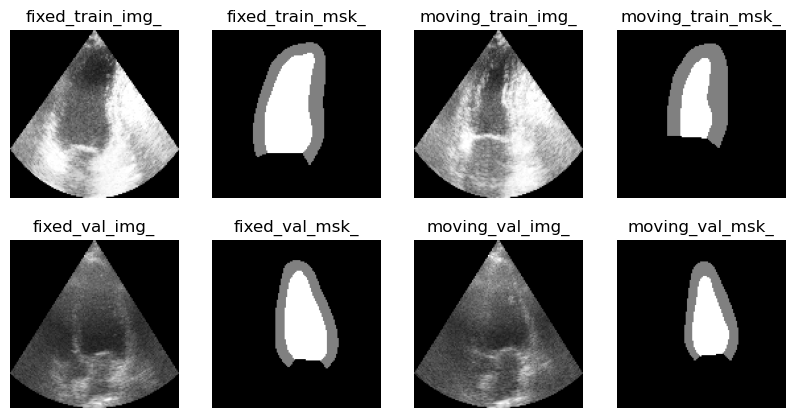

In [7]:
fixed_train_img_ = first(dataloaders["fixed_train_img"])[0][0]
fixed_train_msk_ = first(dataloaders["fixed_train_msk"])[0][0]
moving_train_img_ = first(dataloaders["moving_train_img"])[0][0]
moving_train_msk_ = first(dataloaders["moving_train_msk"])[0][0]

fixed_val_img_ = first(dataloaders["fixed_val_img"])[0][0]
fixed_val_msk_ = first(dataloaders["fixed_val_msk"])[0][0]
moving_val_img_ = first(dataloaders["moving_val_img"])[0][0]
moving_val_msk_ = first(dataloaders["moving_val_msk"])[0][0]


print(f"fixed_train_img_ shape: {fixed_train_img_.shape}")
print(f"fixed_train_msk_ shape: {fixed_train_msk_.shape}")
print(f"moving_train_img_ shape: {moving_train_img_.shape}")
print(f"moving_train_msk_ shape: {moving_train_msk_.shape}")

print(f"fixed_val_img_ shape: {fixed_val_img_.shape}")
print(f"fixed_val_msk_ shape: {fixed_val_msk_.shape}")
print(f"moving_val_img_ shape: {moving_val_img_.shape}")
print(f"moving_val_msk_ shape: {moving_val_msk_.shape}")


print(f"fixed_train_img_ Range: {fixed_train_img_.max()} {fixed_train_img_.min()}")
print(f"fixed_train_msk_ range: {fixed_train_msk_.max()} {fixed_train_msk_.min()} {np.unique(fixed_train_msk_)}")
print(f"moving_train_img_ Range: {moving_train_img_.max()} {moving_train_img_.min()}")
print(f"moving_train_msk_ range: {moving_train_msk_.max()} {moving_train_msk_.min()} {np.unique(moving_train_msk_)}")

print(f"fixed_val_img_ Range: {fixed_val_img_.max()} {fixed_val_img_.min()}")
print(f"fixed_val_msk_ range: {fixed_val_msk_.max()} {fixed_val_msk_.min()} {np.unique(fixed_val_msk_)}")
print(f"moving_val_img_ Range: {moving_val_img_.max()} {moving_val_img_.min()}")
print(f"moving_val_msk_ range: {moving_val_msk_.max()} {moving_val_msk_.min()} {np.unique(moving_val_msk_)}")


plt.figure("check", (10, 5))

plt.subplot(2, 4, 1)
plt.title("fixed_train_img_")
plt.imshow(fixed_train_img_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.title("fixed_train_msk_")
plt.imshow(fixed_train_msk_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title("moving_train_img_")
plt.imshow(moving_train_img_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.title("moving_train_msk_")
plt.imshow(moving_train_msk_, cmap="gray")
plt.axis('off')


plt.subplot(2, 4, 5)
plt.title("fixed_val_img_")
plt.imshow(fixed_val_img_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.title("fixed_val_msk_")
plt.imshow(fixed_val_msk_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.title("moving_val_img_")
plt.imshow(moving_val_img_, cmap="gray")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.title("moving_val_msk_")
plt.imshow(moving_val_msk_, cmap="gray")
plt.axis('off')

plt.show()

In [8]:
# mod = LocalNet(
#     spatial_dims=2,
#     in_channels=2,
#     out_channels=2,
#     num_channel_initial=32,
#     extract_levels=[3],
#     out_activation=None,
#     out_kernel_initializer="zeros")

# inputs = torch.randn((2, 2, img_size, img_size))

# y = mod(inputs)
# print(y.shape)

# import torch, torchinfo
# # from torchviz import make_dot, make_dot_from_trace
    
# # make_dot(y, params=dict(mod.named_parameters()),
# #          show_attrs=False,
# #          show_saved=False).render(fileNames, format="png")

# torchinfo.summary(mod, input_size=(2, 2, img_size, img_size), depth=100)

In [9]:
model = LocalNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=2,
    num_channel_initial=32,
    extract_levels=[3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)

if preTrained:
    model.load_state_dict(torch.load(os.path.join(root_dir, "Vanilla_DLIR_" + dataDir + '_' +str(previousWeight) + '_'+'.pth')))




warp_layer = Warp().to(device)

# image_loss = MSELoss()

image_loss = GlobalMutualInformationLoss()

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)
    

label_SSIM = SSIMLoss(n_channels=1).to(device) # .cuda() if you need GPU support

label_loss = DiceLoss()

# label_loss = MultiScaleLoss(label_loss, scales=[0, 1, 2, 4, 8, 16])

regularization = BendingEnergyLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


# dice_metric = compute_meandice(y_pred, y, include_background=True)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


In [10]:
def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    labels = labels.long()
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_().to(device)
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = Variable(target)
        
    return target

In [11]:
max_epochs = EP
epoch_loss_values = []
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_val_loss_values = []
metric_values = []
best_loss = 1e10
best_dsc = 0

for epoch in range(max_epochs):
    print("-" * 100)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    
    for fixed_train_img_, fixed_train_msk_, moving_train_img_, moving_train_msk_ in zip(fixed_train_img,
                                                                                    fixed_train_msk, moving_train_img,
                                                                                    moving_train_msk):    
        step += 1
        
        optimizer.zero_grad()

        fixed_train_img_ = fixed_train_img_.to(device)
        fixed_train_msk_ = fixed_train_msk_.to(device)
        moving_train_img_ = moving_train_img_.to(device)
        moving_train_msk_ = moving_train_msk_.to(device)
        
        ddf_train = model(torch.cat((moving_train_img_, fixed_train_img_), dim=1))
        
        pred_image_train = warp_layer(moving_train_img_, ddf_train)
        pred_mask_train = warp_layer(moving_train_msk_, ddf_train)

        imageLOSS = image_loss(pred_image_train, fixed_train_img_)
        
        loss = imageLOSS
    
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        dice_metric(y_pred = make_one_hot(pred_mask_train, C=3), y=make_one_hot(fixed_train_msk_, C=3))

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"For epoch: {epoch + 1}, Average train loss: {epoch_loss:.5f} !")
    print(f"For epoch: {epoch + 1}, Average train DSC: {metric:.5f} !\n")
    
    print("-" * 60)
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        val_loss = 0
        val_met = 0
        step = 0
        with torch.no_grad():
            for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk):  

                fixed_val_img_ = fixed_val_img_.to(device)
                fixed_val_msk_ = fixed_val_msk_.to(device)
                
                moving_val_img_ = moving_val_img_.to(device)
                moving_val_msk_ = moving_val_msk_.to(device)
                
                
                ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))
                
                pred_image_val = warp_layer(moving_val_img_, ddf_val)
                pred_mask_val = warp_layer(moving_val_msk_, ddf_val)


                imageLOSS = image_loss(pred_image_val, fixed_val_img_)

                loss = imageLOSS
                
                
    
                val_loss += loss.item()
                step += 1

                
                dice_metric(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3))
                

            val_loss /= step
            epoch_val_loss_values.append(val_loss)
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()
            
            if metric > best_dsc:
                best_loss_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, fileNames+'.pth'))
                print(f"Valid DSC improved from {best_dsc:2.4f} to {metric:2.4f}! Best model is saving as---> {fileNames+'.pth'}")
                best_dsc = metric
                
            print(
                f"\nCurrent mean dice: {metric:.4f} "
                f"\t and \t Current val loss: {val_loss:.4f}\n\n"
                f"Best val DSC: {best_dsc:.4f} "
                f"at epoch number of {best_loss_epoch}")

----------------------------------------------------------------------------------------------------
Epoch 1/100
For epoch: 1, Average train loss: -0.91355 !
For epoch: 1, Average train DSC: 0.82982 !

------------------------------------------------------------
Valid DSC improved from 0.0000 to 0.8445! Best model is saving as---> Vanilla_DLIR_CAMUS_EStoED_A2C_128_.pth

Current mean dice: 0.8445 	 and 	 Current val loss: -0.9324

Best val DSC: 0.8445 at epoch number of 1
----------------------------------------------------------------------------------------------------
Epoch 2/100
For epoch: 2, Average train loss: -0.92558 !
For epoch: 2, Average train DSC: 0.84120 !

------------------------------------------------------------
Valid DSC improved from 0.8445 to 0.8476! Best model is saving as---> Vanilla_DLIR_CAMUS_EStoED_A2C_128_.pth

Current mean dice: 0.8476 	 and 	 Current val loss: -0.9380

Best val DSC: 0.8476 at epoch number of 2
------------------------------------------------

Text(0.5, 0, 'Epochs')

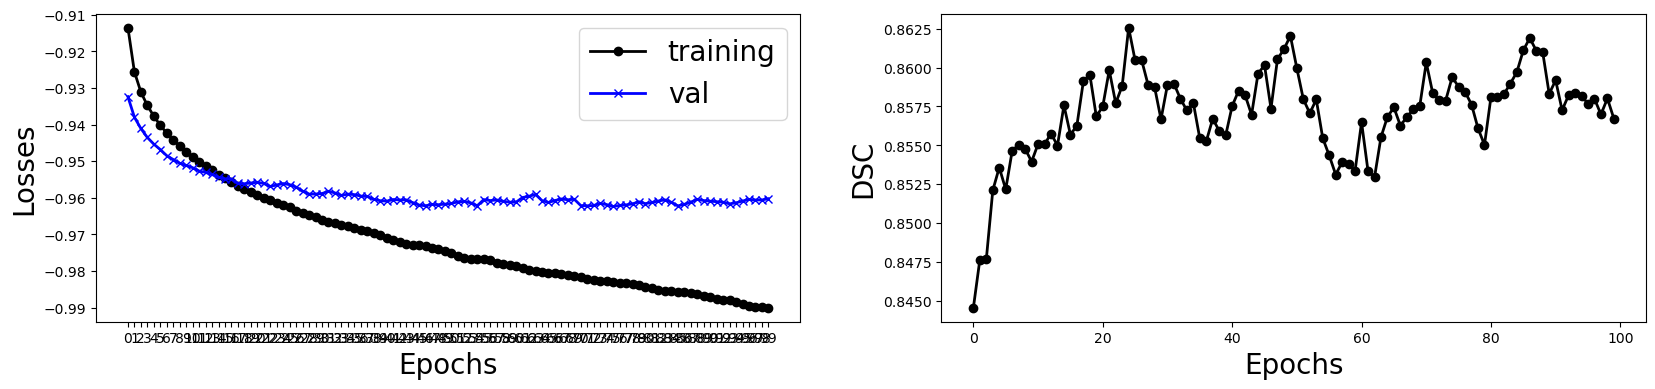

In [12]:
%matplotlib inline
plt.figure("train", (20, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label = 'training', color='k', lw=2, linestyle='-', marker = 'o')
plt.plot(epoch_val_loss_values, label = 'val', color='b', lw=2, linestyle='-', marker = 'x')
plt.legend(fontsize=20, loc='upper right', ncol=1)
plt.xticks(range(0, max_epochs , 1))
plt.ylabel('Losses', fontsize=20)
plt.xlabel('Epochs', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(metric_values, label = 'training', color='k', lw=2, linestyle='-', marker = 'o')
plt.ylabel('DSC', fontsize=20)
plt.xlabel('Epochs', fontsize=20)

In [13]:
def hausdorff (mask1, mask2):
    mask1_class_LV = mask1.copy()
    mask1_class_Myo = mask1.copy()
    
    mask1_class_LV[mask1_class_LV==1] = 0
    mask1_class_Myo[mask1_class_Myo==2] = 0
    
    mask2_class_LV = mask2.copy()
    mask2_class_Myo = mask2.copy()
    
    mask2_class_LV[mask2_class_LV==1] = 0
    mask2_class_Myo[mask2_class_Myo==2] = 0
    
    hausdorff_Myo = (directed_hausdorff(mask1_class_Myo, mask2_class_Myo)[0]+directed_hausdorff(mask2_class_Myo, mask1_class_Myo)[0])/2

    hausdorff_LV = (directed_hausdorff(mask1_class_LV, mask2_class_LV)[0]+directed_hausdorff(mask2_class_LV, mask1_class_LV)[0])/2
    
    return [hausdorff_Myo, hausdorff_LV]

In [14]:
model.load_state_dict(torch.load(os.path.join(root_dir, fileNames+'.pth')))
model.eval()

metric = monai.metrics.MSEMetric()

before_MSEMetric = []
after_MSEMetric = []

before_compute_meandice = []
after_compute_meandice = []

before_compute_hausdorff_distance = []
after_compute_hausdorff_distance = []
                                                                         

for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk): 
    
    fixed_val_img_ = fixed_val_img_.to(device)
    fixed_val_msk_ = fixed_val_msk_.to(device)

    moving_val_img_ = moving_val_img_.to(device)
    moving_val_msk_ = moving_val_msk_.to(device)


    ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))

    pred_image_val = warp_layer(moving_val_img_, ddf_val)
    pred_mask_val = warp_layer(moving_val_msk_, ddf_val)
    
    
    before_MSEMetric.extend(metric(moving_val_img_,fixed_val_img_).detach().cpu().numpy())
    
    after_MSEMetric.extend(metric(pred_image_val,fixed_val_img_).detach().cpu().numpy())
    
#     print(metric(pred_image_val,fixed_val_img_).detach().cpu().numpy())

    before_compute_hausdorff_distance.extend((compute_hausdorff_distance(y_pred = make_one_hot(moving_val_msk_, C=3), y=make_one_hot(fixed_val_msk_, C=3), directed=True)).detach().cpu().numpy())
    after_compute_hausdorff_distance.extend((compute_hausdorff_distance(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3), directed=True)).detach().cpu().numpy()) 
    
    
    before_compute_meandice.extend((compute_meandice(y_pred = make_one_hot(moving_val_msk_, C=3), y=make_one_hot(fixed_val_msk_, C=3))).detach().cpu().numpy())
    after_compute_meandice.extend((compute_meandice(y_pred = make_one_hot(pred_mask_val, C=3), y=make_one_hot(fixed_val_msk_, C=3))).detach().cpu().numpy()) 
    
    
#     break

print(np.array(before_MSEMetric).shape)
print(np.array(after_MSEMetric).shape)

print(np.array(before_compute_meandice).shape)
print(np.array(after_compute_meandice).shape)

print()

print(f'MSEMetric W/O registration {np.mean(np.array(before_MSEMetric))}')
print(f'MSEMetric W/ registration = {np.mean(np.array(after_MSEMetric))}')

print(f'Mean dice W/O registration = {np.mean(np.array(before_compute_meandice), axis=0)}')
print(f'Mean dice W/ registration = {np.mean(np.array(after_compute_meandice), axis=0)}')

print(f'Hausdorff_distance W/O registration = {np.mean(np.array(before_compute_hausdorff_distance), axis=0)}')
print(f'Hausdorff_distance W/ registration = {np.mean(np.array(after_compute_hausdorff_distance), axis=0)}')

print()

print('----------------For Report Metric +/- Std-----------------------')
print(f'Mean dice W/O registration = {np.mean(np.mean(np.array(before_compute_meandice), axis=0))} + {np.mean(np.std(np.array(before_compute_meandice), axis=0))}')
print(f'Mean dice W/ registration = {np.mean(np.mean(np.array(after_compute_meandice), axis=0))} + {np.mean(np.std(np.array(after_compute_meandice), axis=0))}')

print(f'Hausdorff_distance W/O registration = {np.mean(np.mean(np.array(before_compute_hausdorff_distance), axis=0))} + {np.mean(np.std(np.array(before_compute_hausdorff_distance), axis=0))}')
print(f'Hausdorff_distance W/ registration = {np.mean(np.mean(np.array(after_compute_hausdorff_distance), axis=0))} + {np.mean(np.std(np.array(after_compute_hausdorff_distance), axis=0))}')

df = ({
     'before_compute_hausdorff_distance':np.mean(np.array(before_compute_hausdorff_distance), axis=1),
     'after_compute_hausdorff_distance'   : np.mean(np.array(after_compute_hausdorff_distance), axis=1),
     'before_compute_meandice':np.mean(np.array(before_compute_meandice), axis=1),
     'after_compute_meandice':np.mean(np.array(after_compute_meandice), axis=1),
     'before_MSEMetric': np.mean(np.array(before_MSEMetric), axis=1),
     'after_MSEMetric':np.mean(np.array(after_MSEMetric), axis=1)
})

pd.DataFrame(df).to_csv(fileNames+'.csv')

<function compute_meandice at 0x7f99333df3a0>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.


(50, 1)
(50, 1)
(50, 3)
(50, 3)

MSEMetric W/O registration 0.010573032312095165
MSEMetric W/ registration = 0.0056680249981582165
Mean dice W/O registration = [0.9702857  0.67652863 0.76016235]
Mean dice W/ registration = [0.97711253 0.74008644 0.8705212 ]
Hausdorff_distance W/O registration = [7.53842438 8.05412788]
Hausdorff_distance W/ registration = [12.13348056  9.50802803]

----------------For Report Metric +/- Std-----------------------
Mean dice W/O registration = 0.8023255467414856 + 0.05499821901321411
Mean dice W/ registration = 0.8625733852386475 + 0.04336421564221382
Hausdorff_distance W/O registration = 7.796276131049524 + 2.1635506400766005
Hausdorff_distance W/ registration = 10.820754296619338 + 3.7133824845364787


In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, fileNames+'.pth')))
model.eval()
                                          

for fixed_val_img_, fixed_val_msk_, moving_val_img_, moving_val_msk_ in zip(fixed_val_img, fixed_val_msk,
                                                                                        moving_val_img, moving_val_msk): 
    
    fixed_val_img_ = fixed_val_img_.to(device)
    fixed_val_msk_ = fixed_val_msk_.to(device)

    moving_val_img_ = moving_val_img_.to(device)
    moving_val_msk_ = moving_val_msk_.to(device)


    ddf_val = model(torch.cat((moving_val_img_, fixed_val_img_), dim=1))

    pred_image_val = warp_layer(moving_val_img_, ddf_val)
    pred_mask_val = warp_layer(moving_val_msk_, ddf_val)
    
    
    break

fixed_val_img_ = fixed_val_img_.detach().cpu().numpy()[:, 0]
fixed_val_msk_ = fixed_val_msk_.detach().cpu().numpy()[:, 0]

moving_val_img_ = moving_val_img_.detach().cpu().numpy()[:, 0]
moving_val_msk_ = moving_val_msk_.detach().cpu().numpy()[:, 0]

pred_image_val = pred_image_val.detach().cpu().numpy()[:, 0]
pred_mask_val = pred_mask_val.detach().cpu().numpy()[:, 0]

In [16]:
def colored (pred_img, true_img): 
    bitwise_and = cv2.bitwise_and(pred_img, true_img)
    
    TP = np.stack((np.zeros_like(bitwise_and), bitwise_and, np.zeros_like(bitwise_and)), axis=-1)
    
    FN = np.stack((true_img-bitwise_and,
                   true_img-bitwise_and,
                   np.zeros_like(true_img-bitwise_and)), axis=-1)
    
    FP = np.stack((pred_img-bitwise_and,
                   pred_img-bitwise_and,
                  np.zeros_like(pred_img-bitwise_and)), axis=-1)
    
    return (255*(TP+FN+FP)).astype('uint8')

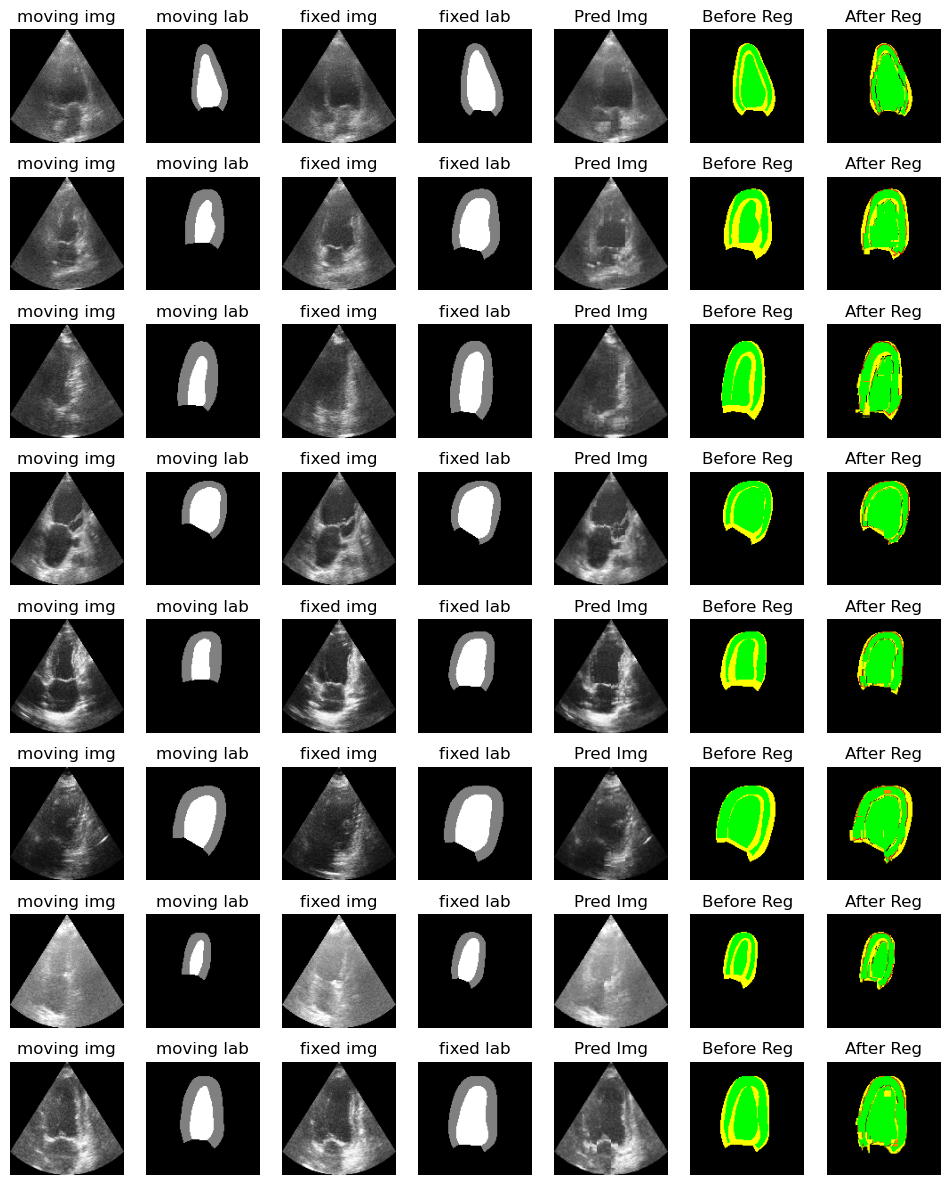

In [17]:
%matplotlib inline
batch_size = testBatch
plt.subplots(batch_size, 7, figsize=(12, 15))

for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 7, b * 7 + 1)
    plt.axis('off')
    plt.title("moving img")
    plt.imshow(moving_val_img_[b], cmap="gray")
    
    # moving label
    plt.subplot(batch_size, 7, b * 7 + 2)
    plt.axis('off')
    plt.title("moving lab")
    plt.imshow(moving_val_msk_[b], cmap="gray")
    
    
    # fixed image
    plt.subplot(batch_size, 7, b * 7 + 3)
    plt.axis('off')
    plt.title("fixed img")
    plt.imshow(fixed_val_img_[b], cmap="gray")
    
    # fixed label
    plt.subplot(batch_size, 7, b * 7 + 4)
    plt.axis('off')
    plt.title("fixed lab")
    plt.imshow(fixed_val_msk_[b], cmap="gray")
    
    
    # warped moving
    plt.subplot(batch_size, 7, b * 7 + 5)
    plt.axis('off')
    plt.title("Pred Img")
    plt.imshow(pred_image_val[b], cmap="gray")


    # warped moving
    plt.subplot(batch_size, 7, b * 7 + 6)
    plt.axis('off')
    plt.title("Before Reg")
    plt.imshow(colored(moving_val_msk_[b], fixed_val_msk_[b]))
    
    
    # warped moving
    plt.subplot(batch_size, 7, b * 7 + 7)
    plt.axis('off')
    plt.title("After Reg")
    plt.imshow(colored(pred_mask_val[b], fixed_val_msk_[b]))
    
plt.axis('off')
plt.show()